In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# your function must import layout and constants
# this is structured to work both in Jupyter notebook and from the command line
try:
    from . import layout
    from . import constants
except ImportError:
    import layout
    import constants

import logging
import re
import json
import secrets
from time import time
from pathlib import Path
from datetime import datetime
from os import path

import requests
from dictor import dictor
import sys

In [6]:
from library import PluginTools

In [7]:
def _time_now():
    return datetime.now().strftime("%H:%M")

In [8]:
def _fetch_quotes():
    '''fetch quotes from reddit'''
    error = False
    logging.debug('fetching data from reddit')
    raw_quotes = [constants.error_text]
    try:
        r = requests.get(constants.quotes_url, headers=constants.headers)
    except requests.RequestException as e:
        logging.error(f'failed to fetch quotes from {constants.quotes_url}, {e}')
        return (raw_quotes, True)
    if r.status_code == 200:
        try:
            json_data = dictor(r.json(), constants.quote_data_addr)
            raw_quotes = [dictor(q, constants.quote_title_addr) for q in json_data]
        except json.JSONDecodeError as e:
            logging.error(f'bad json data: {e}')
            raw_quotes = [constants.error_text]
            error = True
    else:
        logging.warning(f'error accessing {constants.quotes_url}: code {r.status_code}')
        raw_quotes = [constants.error_text]
        error = True
        
    if len(raw_quotes) < 1:
        raw_quotes = [constants.error_text]
        error = True
        
    return (raw_quotes, error)


In [9]:
def _process_quotes(raw_quotes):
    processed_quotes = []
    logging.debug(f'processing {len(raw_quotes)} quotes')
    for quote in raw_quotes:
        # make sure we have a string to work with
        quote = str(quote)
        # sub double quotes for any other quote character or '' 
        q = re.sub('“|”|\'\'|"', '', quote)
        # sub single quote for ’ character
        q = re.sub('’', "'", q)
        # sub minus for endash, emdash, hyphen, ~
        q = re.sub('-|–|—|~|--|―', '-', q)
        # clean trailing whitespace in quotes
        q = re.sub('\s+"', '"', q)
        # split quote from attirbution
        match = re.match('(.*)\s{0,}-\s{0,}(.*)', q)

        if hasattr(match, 'groups'):
            if len(match.groups()) > 1:
                text = match.group(1).strip()
                attribution = match.group(2).strip().title()
            else:
                text = match.group(1).strip()
                attribution = None
        else:
            text = q.strip()
            attribution = None

        # append quotes to dictionary
        
        processed_quotes.append({'len': len(q), 'text': text, 'attribution': attribution})
    return processed_quotes


In [10]:
# make sure this function can accept *args and **kwargs even if you don't intend to use them
def update_function(self, *args, **kwargs):
    '''update function for reddit_quote plugin
    
    Scrapes quotes from reddit.com/r/quotes and displays them one at a time
    
   Requirements:
        self.config(`dict`): {
        'max_length': 144,   # name of player to track
        'idle_timeout': 10,               # timeout for disabling plugin
    }
    self.cache(`CacheFiles` object)

    Args:
        self(namespace): namespace from plugin object
        
    Returns:
        tuple: (is_updated(bool), data(dict), priority(int))   
        
    This plugin is inspired by and based on the veeb.ch [stonks project](https://github.com/veebch/stonks)
    
    %U'''  

    
    logging.info(f'update function for {constants.name}')
    json_file = self.cache.path/Path(constants.json_file)
    
    max_length = self.config.get('max_length', constants.required_config_options['max_length'])
    max_retries = self.config.get('max_retries', constants.required_config_options['max_retries'])
    
    try:
        max_length = int(max_length)
        max_retries = int(max_retries)
    except ValueError as e:
        logging.warning('non-numeric values provided in configuration file for max_length or max_retries')
    
    is_updated = False
    data = {}
    priority = 2**16
    
    logging.debug(f'checking mtime of cached json file: {json_file}')
    
    # check the age of the cached data
    try:
        mtime  = time() - path.getmtime(json_file)
        logging.debug(f'age of {json_file}: {mtime}')
    except OSError as e:
#         logging.info(f'{e}')
        mtime = 2**16
    except json.JSONDecodeError as e:
        logging.info(f'{e}')
        mtime = 2**16
        
    
    if json_file.exists() and mtime < constants.json_max_age:
        try:
            logging.debug('using cached reddit data')
            with open(json_file) as jf:
                json_data = json.load(jf)
        except OSError as e:
            logging.warning(f'could not open cached JSON file: {e}')
        except json.JSONDecodeError as e:
            logging.error(f'could not decode JSON file: {e}')
            json_data = None
    else:
        logging.debug('cached data expired, fetching fresh data')
        json_data = None
            
    
    if not json_data:
        logging.debug('downloading fresh data from reddit')
        raw_quotes, fetch_error = _fetch_quotes()
        json_data = _process_quotes(raw_quotes)
        
        if fetch_error:
            logging.warning('failed to fetch data due to previous errors. skipping cache.')
        else:
            logging.info('caching data')
            try:
                with open(json_file, 'w')  as jf:
                    json.dump(json_data, jf)
            except OSError as e:
                logging.error(f'failed to cache data: {e}')
            
    if json_data:  
        for i in range(0, max_retries):
            logging.debug(f'choosing quote with length < {max_length} characters')
            my_quote = secrets.choice(json_data)
            if my_quote['len'] < max_length:
                break
            else:
                logging.debug(f'quote was too long: {my_quote["len"]} characters')
        if my_quote['attribution']:
            attribution = my_quote['attribution']
            my_quote['attribution'] = f'{constants.attribution_char}{attribution}'
        logging.debug(my_quote)
        
        data = my_quote
        data['time'] = _time_now()
        data['tag_image'] = constants.tag_image
        is_updated = True
        priority = self.max_priority

    if 'text_color' in self.config or 'bkground_color' in self.config:
        logging.info('using user-defined colors')
        colors = PluginTools.text_color(config=self.config, mode=self.screen_mode,
                               default_text=self.layout.get('fill', 'WHITE'),
                               default_bkground=self.layout.get('bkground', 'BLACK'))

        text_color = colors['text_color']
        bkground_color = colors['bkground_color']


        # set the colors
        logging.debug(f'trying to set fill and background for sections: {list(self.layout.keys())}')
        for section in self.layout:
            if self.layout[section].get('rgb_support', False):
                logging.debug(f'setting {section} layout colors to fill: {text_color}, bkground: {bkground_color}')
                self.layout_obj.update_block_props(section, {'fill': text_color, 'bkground': bkground_color}) 

            else:
                logging.debug(f'section {section} does not support RGB colors')
        
        
    return (is_updated, data, priority)

In [13]:
!jupyter-nbconvert --to python --template python_clean reddit_quote.ipynb

[NbConvertApp] Converting notebook reddit_quote.ipynb to python
[NbConvertApp] Writing 8310 bytes to reddit_quote.py


In [ ]:
# Jupyter notebook magic to create a symbolic to the library directory
# this will allow you to import the Plugin() module 
!ln -s ../../library ./


DEBUG:root:text supports RGB
DEBUG:root:attribution supports RGB
DEBUG:root:time supports RGB
DEBUG:root:[[----checking default values for layout----]
DEBUG:root:section: [-------------text-------------]
DEBUG:root:adding "font_size: None"
DEBUG:root:adding "maxchar: None"
DEBUG:root:adding "dimensions: None"
DEBUG:root:section: [---------attribution----------]
DEBUG:root:adding "font_size: None"
DEBUG:root:adding "maxchar: None"
DEBUG:root:adding "dimensions: None"
DEBUG:root:section: [-------------time-------------]
DEBUG:root:adding "font_size: None"
DEBUG:root:adding "maxchar: None"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "padding: 0"
DEBUG:root:[[....calculating layouts....]]
INFO:root:section: [.............text.............]
DEBUG:root:resolution: (800, 600)
DEBUG:root:width: 1, height: 0.75
DEBUG:root:absolute coordinates provided
DEBUG:root:block coordinates: (0, 0)
INFO:root:section: [.........attribution..........]
DEBUG:root:resolution: (800, 600)
DEBUG:root:

DEBUG:root:checking fill and background color
DEBUG:root:border config: {'fill': None, 'width': 0}
DEBUG:root:border config: {'fill': None, 'width': 0}
DEBUG:root:set fill: RED
INFO:root:using WaveShare color: RED
DEBUG:root:checking fill and background color
DEBUG:root:block area: (800, 30)
DEBUG:root:padded area: [800, 30]
DEBUG:root:creating Block
DEBUG:root:resetting font to match size 31
DEBUG:root:calculating maximum characters for font ('Josefin Sans', 'Light') at size 31
DEBUG:root:calculated average character width: 17.098591549295776
DEBUG:root:maximum characters per line: 47
DEBUG:root:formatting string: NONE
DEBUG:root:text size: (97, 31)
INFO:root:the text will spill outside of padded area using these values
DEBUG:root:paste coordinates: (0, 0)
DEBUG:root:"len" is not a recognized block, skipping
DEBUG:root:formatting string: If you want to draw something, don't ask someone else to sharpen your pencil
DEBUG:root:text size: (603, 248)
DEBUG:root:pasting hcenterd
DEBUG:root:

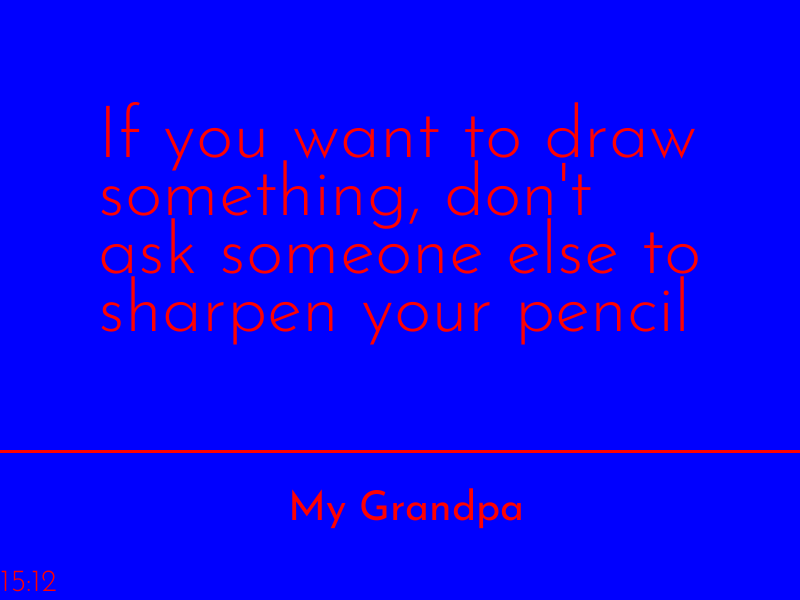

In [12]:
# # this code snip simulates running from within the display loop use this and the following
# # cell to test the output
# import logging
# logging.root.setLevel('DEBUG')
# from library.CacheFiles import CacheFiles
# from library.Plugin import Plugin
# from IPython.display import display

# test_plugin = Plugin(resolution=(800, 600), screen_mode='RGB')
# test_plugin.refresh_rate = 5
# l = layout.layout
# # l = layout.quote
# test_plugin.config = {
#     'text_color': 'RED',
#     'bkground_color': 'random'
# }
# test_plugin.layout = l
# test_plugin.cache = CacheFiles()
# test_plugin.update_function = update_function
# test_plugin.update()
# test_plugin.image